# Solve the group Lasso problem (using Fista and coordinate descent)


$$ min \frac{1}{N} \sum_n \left( y[n] - \sum_{j,k} X[n]_{j,k} \beta_{j,k} \right)^2  + \frac{\alpha}{2} \sum_j\left( \sum_k|\beta_{j,k}| \right)^2$$

## todo 
Use Krishnapuram's minorization if it's faster

In [74]:
multiply(reshape(weight, (1000,1)),X)

array([[-0.42669877,  0.29668152, -0.10066115, ...,  0.9350544 ,
         1.20547642, -1.07842679],
       [ 0.86983601,  0.16784762,  1.99511086, ..., -0.59534334,
         1.06308213,  0.40705189],
       [-0.35385605,  0.58638942,  1.84715516, ..., -0.86965832,
        -1.16826893, -0.74818827],
       ..., 
       [-1.15450956,  0.6691788 , -0.37614964, ..., -0.11485919,
         1.77674752,  0.01095968],
       [ 0.94385436,  0.10042727, -0.04454939, ...,  0.33019859,
         0.68450555,  0.54706842],
       [ 1.23247515,  2.25107138,  1.56318529, ..., -1.37800813,
         1.28553305,  0.66171722]])

In [69]:
from numpy import linalg
linalg.pinv( dot(X.T, dot(diag(weight),X) ) )

array([[  1.16459408e-03,  -2.57047623e-04,  -2.12399521e-04, ...,
          3.01728686e-05,   5.00763828e-05,  -3.35758547e-05],
       [ -2.57047623e-04,   1.02948520e-03,  -1.66699628e-04, ...,
          3.11398149e-05,  -1.15698141e-05,  -3.13775915e-05],
       [ -2.12399521e-04,  -1.66699628e-04,   1.03325500e-03, ...,
         -4.10535836e-06,   3.43319746e-05,   7.00417919e-06],
       ..., 
       [  3.01728686e-05,   3.11398149e-05,  -4.10535836e-06, ...,
          9.85115778e-04,  -1.38652329e-04,  -1.24498180e-04],
       [  5.00763828e-05,  -1.15698141e-05,   3.43319746e-05, ...,
         -1.38652329e-04,   1.10052756e-03,  -1.75076075e-04],
       [ -3.35758547e-05,  -3.13775915e-05,   7.00417919e-06, ...,
         -1.24498180e-04,  -1.75076075e-04,   9.18693580e-04]])

solve with fista took 7.74 seconds
converged in 17 its with tol=5.97183e-07 with IC= 0.215932 


<IPython.core.display.Javascript object>


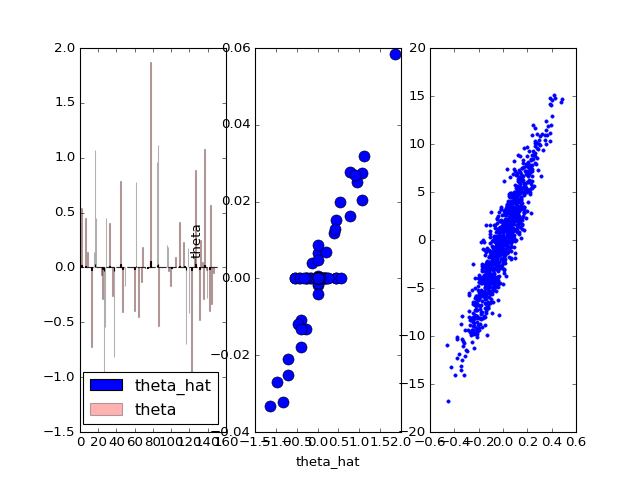

solve with OSL took 0.02 seconds
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     47.25
Date:                Tue, 22 Mar 2016   Prob (F-statistic):               0.00
Time:                        07:31:52   Log-Likelihood:                -2011.6
No. Observations:                1000   AIC:                             4323.
Df Residuals:                     850   BIC:                             5059.
Df Model:                         150                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.03

In [47]:
%matplotlib nbagg
from pylab import *
import numpy as np
import sys
sys.path.append('d:/research/python')
import algos.fista as fs
from imp import reload
from numpy import linalg
from numba import jit
reload(fs)
from pandas import * 
from functools import partial
from multiprocessing.pool import ThreadPool
from random import sample
from utils.timer import Timer
from statsmodels.regression.linear_model import OLS

mapper = ThreadPool().map

########################################################
# generate the test data
########################################################

n = 10000;
n_groups = 30;               #number of groups
sigma = 2
grps = array([5]*n_groups)   #variables in one group
p = sum(grps)
tgt_l2_norm = 1*n_groups;
alpha = 5.0;

@jit(nopython=True, nogil=True)
def shrink(theta, eps):
    p = len(theta)
    beta2 = zeros(p)
    for i in range(p):
        shv = abs(theta[i])-eps
        beta2[i] = sign(theta[i])*shv if shv > 0 else 0
    return beta2

@jit(nopython=True, nogil=True)
def l2norm(theta):
    nrm = 0;
    for i in range(len(theta)):
        nrm += pow(theta[i], 2)
    return nrm

@jit(nopython=True, nogil=True)
def group_norm(theta, grps):
    l2 = 0; 
    i = 0;
    for g in grps:        
        l1 = 0;
        for v in range(g):
            l1 += abs(theta[i])
            i += 1;
        l2 += pow(l1,2)
    assert i == len(theta), 'group_norm fail'
    return l2            

if False:
    theta_org = array(randn(p))
    theta = theta_org
    while group_norm(theta, grps) > tgt_l2_norm:
        theta = shrink(theta, 0.01)    
    # print( 'shrunk from ... to \n',  '\n'.join(str(v) for v in zip(beta_org,beta)  ))

    X = array( [cos( arange(n)*ceil(pp/5) )+randn(n) for pp in range(1,p+1) ] ).transpose();
    yo = dot(X, theta)
    weight = ones(len(yo))
    y = yo + sigma*randn(n)

    # plot(X[:,2], y, '.')
    # #print(beta, group_norm(theta, grps), shrink(theta,0.01),  )
    # eps_vec = linspace(0, max(abs(theta)), 100)
    # norm_vec = zeros(len(eps_vec))
    # for i in range(len(eps_vec)):
    #     norm_vec[i] = group_norm( shrink(theta, eps_vec[i]),grps )
    # %matplotlib inline
    # plot(eps_vec, norm_vec, '.')    

########################################################
# Functions for the group Lasso penatly
########################################################

@jit(nogil=True)
def f(theta):
    return 0.5*sum(pow(y-dot(X, theta), 2)*weight)/n

@jit(nogil=True)
def grad_f(theta):
    return -dot( (y - dot(X, theta))* weight, X )/n;

def g(theta):    
    return alpha/2 * group_norm(theta, grps)

@jit(nopython=True, nogil=True)
def cd(bh, kappa, tol, max_its):
    '''
    solve the following problem using coordinate descent within each Lasso block
           min_b  t/2 (b - bh)^2   + \alpha/2 (|b|_1)^2
    ==>    min_b  (b - bh)^2   + \kappa (|b|_1)^2
    ==>    (b-bh)_i + \kappa |b|_1 \del(b_i) = 0
    ==>    bh_i - b_i = \del(b_i) [ \kappa\sum_{j\neq i} |b_j| + \kappa |b_i| ]
    
    If b_i == 0 ==>  bh_i \in \kappa.[-1,+1] \sum_{j\neq i} |b_j|
    If b_i > 0  ==>  bh_i - b_i =  \kappa\sum_{j\neq i} |b_j| + \kappa |b_i|
    If b_i < 0  ==>  bh_i - b_i = -\kappa\sum_{j\neq i} |b_j| - \kappa |b_i|
    '''          
    n = len(bh);
    b = zeros(n);  b[:] = bh[:];
    bp = empty(n);     
    it = 0
    while True:
        bp[:] = b[:];
        it += 1;
        for i in range(n):
            sbj = 0;
            for j in range(n):
                if j == i: continue
                sbj += abs(b[j])
            if bh[i] >= -kappa*sbj and  bh[i] <= kappa *sbj : 
                b[i] = 0;                                
            elif bh[i] - kappa*sbj > 0:
                b[i] = (bh[i] - kappa*sbj)/(1+kappa)
            elif bh[i] + kappa*sbj < 0:
                b[i] = (bh[i] + kappa*sbj)/(1+kappa)
            else:
                #'bh[i]=%g, kappa*sbj=%g'%(bh[i], kappa*sbj)
                assert False , 'Asserting in cd failed' 
        if l2norm(b-bp)/len(bp) < tol or it > max_its: break
    return b, l2norm(b-bp), it
    
@jit(nopython=True, nogil=True)
def prox_g(theta_hat, t, tol, max_its):
    '''    
    argmin_beta  alpha/2 |beta|_{2,1} + t/2 |beta-beta_hat|^2_2
    Do coordinate descent in each blcok.
    '''
    kappa = alpha/t;    
    theta_out = zeros(len(theta_hat))
    conv = zeros(len(grps))
    its = zeros(len(grps))
    gs = 0;
    for gi in range(len(grps)):        
        ge = gs + grps[gi]
        theta_out[gs:ge], conv[gi], its[gi] = cd(theta_hat[gs:ge], kappa, tol, max_its)
        gs = ge;
    return theta_out
    
# print( sqrt(2*f(theta)), grad_f(theta), grad_f( theta+randn(len(theta))*0.01 ))    
# btst = randn(3000)
# %timeit b2, nrm, it  = cd( btst, 0.2, 1e-6, max_its=100)
# print(nrm, it)
# xx = DataFrame(res)
# print(xx)
# print( "\n".join(str(v) for v in zip(beta, b) ), nrm, it)
# bout, conv, its = prox_g( beta, 1, 1e-3, 100)
# print( "\n".join(str(v) for v in zip(beta, bout) ), conv, its)

itlist=[]

with Timer('solve with fista'):
    theta_hat, its, chg = fs.fista( 
        x_o=zeros(len(theta)), f=f, g=g, grad_f=grad_f, 
        prox_g=partial(prox_g, tol=1e-6, max_its=100), 
        verbose=False, bt_flg=True, L_0=10, debug=itlist, tol=1e-6
    )
y_hat  = dot(X,theta_hat)
print( 'converged in %d its with tol=%g with IC= %g '%(its,chg, sqrt(1-l2norm(y_hat-y)/l2norm(y) ) ) )
subplot(131); 
bar(arange(p),theta_hat, color='b', label='theta_hat')
bar(arange(p),theta, color='r', alpha=0.3, label='theta');
gca().legend(loc='lower right');
subplot(132); 
plot( theta, theta_hat, 'o', markersize=10); gca().set_xlabel('theta_hat'); gca().set_ylabel('theta');
from random import sample
ih = sample(range(len(y_hat)), 1000)
subplot(133); plot(y_hat[ih], yo[ih], '.')


with Timer('solve with OSL'):
    xx = OLS(
        endog=y,
        exog=X
    ).fit()
print( xx.summary() )

converged in 99 its with tol=3.59423e+87 with IC= nan 


<IPython.core.display.Javascript object>


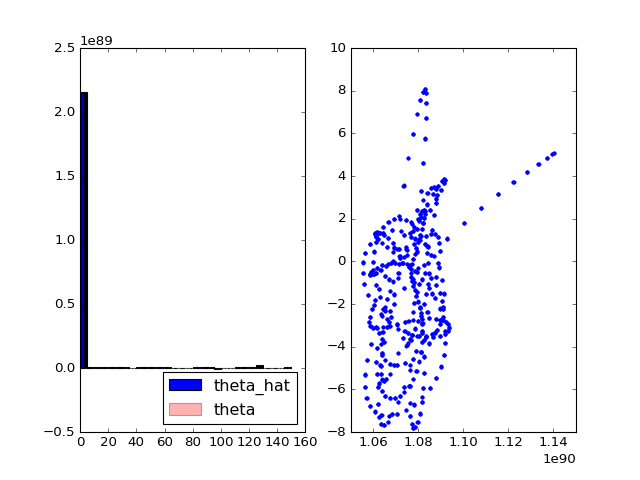

In [22]:
%matplotlib nbagg
print( 'converged in %d its with tol=%g with IC= %g '%(its,chg, sqrt(1-l2norm(y_hat-y)/l2norm(y) ) ) )
subplot(121); 
bar(arange(p),theta_hat, color='b', label='theta_hat')
bar(arange(p),theta, color='r', alpha=0.3, label='theta');
gca().legend(loc='lower right');
from random import sample
ih = sample(range(len(y_hat)), 1000)
subplot(122); plot(y_hat[ih], yo[ih], '.')

In [7]:
ih = sample(range(len(y_hat)), 100)
